<a href="https://colab.research.google.com/github/Loumstar/Improving-RoBERTa/blob/master/main_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Fri Mar  4 13:10:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Setup


## Installations & Imports

In [14]:
!pip install transformers sentencepiece ipywidgets tensorboardx wandb matplotlib
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [15]:
import logging
import string
import wandb
import nltk
import torch
import re
import string

import torch.nn as nn
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from operator import itemgetter
from urllib import request

from transformers import Trainer, TrainingArguments
from transformers import DebertaTokenizer, DebertaForSequenceClassification

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer

from torch.utils.data import DataLoader

if not torch.cuda.is_available():
  print('WARNING: You may want to change the runtime to GPU for faster training!')
  DEVICE = 'cpu'
else:
  print("CUDA available.")
  DEVICE = 'cuda:0'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
CUDA available.


## Mount Google Drive

In [16]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/'
%mkdir './nlp-cswrk'
%cd './nlp-cswrk' 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive
mkdir: cannot create directory ‘./nlp-cswrk’: File exists
/content/drive/MyDrive/nlp-cswrk


## Logging

In [17]:
# prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

## Download Datasets

In [18]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/train_semeval_parids-labels.csv"
module_name = module_url.split('/')[-1]

print(f'Fetching {module_url}')
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  b = f.read()
  outf.write(b.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/train_semeval_parids-labels.csv


In [19]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/dev_semeval_parids-labels.csv"
module_name = module_url.split('/')[-1]

print(f'Fetching {module_url}')
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  b = f.read()
  outf.write(b.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/dev_semeval_parids-labels.csv


In [20]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]

print(f'Fetching {module_url}')
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py


In [21]:
from dont_patronize_me import DontPatronizeMe

dpm = DontPatronizeMe('.', '.')
dpm.load_task1()

In [22]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

## Data Analysis

### Setup

In [23]:
df = dpm.train_task1_df

print("Whole dataset info:")
print(df.shape)
print(df.columns)

patr_df = df.loc[df.label == 1]
unpatr_df = df.loc[df.label == 0]

patr_df_length = patr_df.shape[0]
unpatr_df_length = unpatr_df.shape[0]

print("Patronising and Unpatronising shapes:")
print(patr_df.shape, unpatr_df.shape)

Whole dataset info:
(10469, 7)
Index(['par_id', 'art_id', 'keyword', 'country', 'text', 'label',
       'orig_label'],
      dtype='object')
Patronising and Unpatronising shapes:
(993, 7) (9476, 7)


### General Info

#### Balance of Classes

In [28]:
def get_binary_label_distribution(df, axis):
    _, _, [patch0, patch1] = axis.hist(df.label.map(int), 
                                       bins=[-0.5, 0.5, 1.5])

    patch0.set_facecolor("tab:blue")
    patch1.set_facecolor("tab:orange")

    axis.set_xticks([0, 1])
    axis.set_xticklabels(["Unpatronising", "Patronising"])

def get_multi_label_distribution(df, axis):
    _, _, patches = axis.hist(df.orig_label.map(int), 
                    bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5])

    colours = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]

    for patch, colour in zip(patches, colours):
        patch.set_facecolor(colour)

Text(0.5, 0, 'Levels of condescension')

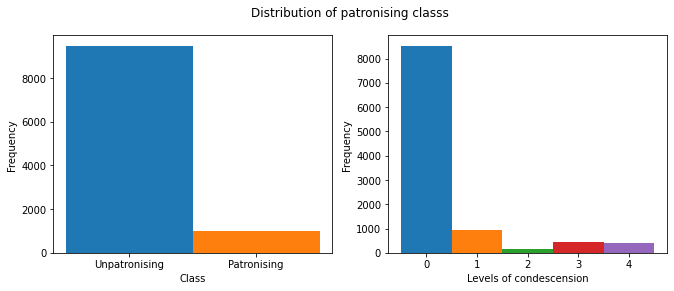

In [29]:
figure, (binary_ax, multi_ax) = plt.subplots(1, 2)

figure.suptitle("Distribution of patronising classs")
figure.set_size_inches((11, 4))

get_binary_label_distribution(df, binary_ax)

binary_ax.set_ylabel("Frequency")
binary_ax.set_xlabel("Class")

get_multi_label_distribution(df, multi_ax)

multi_ax.set_ylabel("Frequency")
multi_ax.set_xlabel("Levels of condescension")

#### Distribution of Languages

Text(0.5, 0, 'Country')

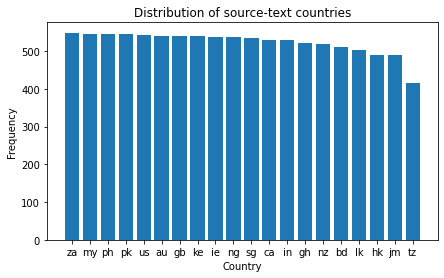

In [30]:
figure, axis = plt.subplots()

figure.set_size_inches((7, 4))

labels, counts = np.unique(df.country, return_counts=True)

label_counts = list(zip(labels, counts))
label_counts.sort(key=itemgetter(1), reverse=True)
labels_sorted, counts_sorted = zip(*label_counts)

axis.bar(np.arange(len(counts)), counts_sorted, tick_label=labels_sorted)

axis.set_title("Distribution of source-text countries")
axis.set_ylabel("Frequency")
axis.set_xlabel("Country")

#### Distribution of Categories

Text(0.5, 0, 'Category')

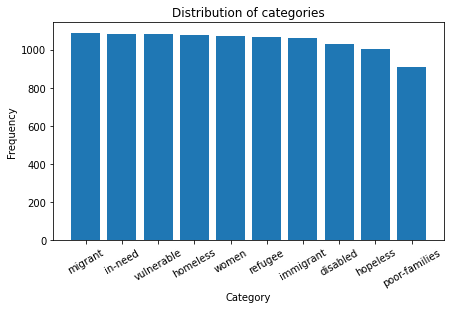

In [31]:
figure, axis = plt.subplots()

figure.set_size_inches((7, 4))

labels, counts = np.unique(df.keyword, return_counts=True)

label_counts = list(zip(labels, counts))
label_counts.sort(key=itemgetter(1), reverse=True)
labels_sorted, counts_sorted = zip(*label_counts)

axis.bar(np.arange(len(counts)), counts_sorted, tick_label=labels_sorted)

axis.tick_params(axis='x', labelrotation=30)

axis.set_title("Distribution of categories")
axis.set_ylabel("Frequency")
axis.set_xlabel("Category")

### Text Analysis

#### Average Character Length

Average number of characters for
	- patronising class: 288.45
	- unpatronising class: 265.40


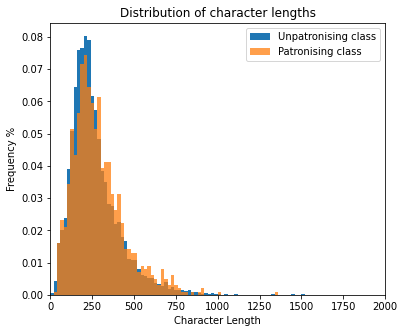

In [32]:
unpatr_series = unpatr_df.text.str.len()
patr_series = patr_df.text.str.len()

print(f"Average number of characters for"
      f"\n\t- patronising class: {patr_series.mean():.2f}"
      f"\n\t- unpatronising class: {unpatr_series.mean():.2f}")

(unpatr_counts, unpatr_bins) = np.histogram(unpatr_series, bins=100, range=(0, 2000))
(patr_counts, patr_bins) = np.histogram(patr_series, bins=100, range=(0, 2000))

figure, axis = plt.subplots()
figure.set_size_inches((6, 5))

axis.hist(unpatr_bins[:-1], unpatr_bins, alpha=1, label="Unpatronising class",
          weights=unpatr_counts / unpatr_df_length)

axis.hist(patr_bins[:-1], patr_bins, alpha=0.75, label="Patronising class",
          weights=patr_counts / patr_df_length)

axis.set_title("Distribution of character lengths")
axis.set_ylabel("Frequency %")
axis.set_xlabel("Character Length")
axis.set_xlim((0, 2000))
axis.legend()

#### Average Number of Words

Average number of words for
	- patronising class: 53.62
	- unpatronising class: 47.88


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Average word length for
	- patronising class: 4.43
	- unpatronising class: 4.62


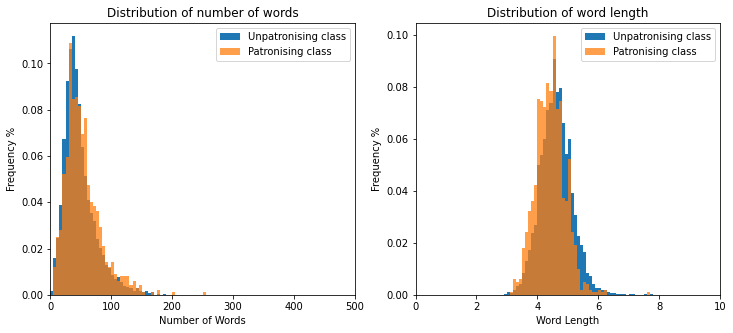

In [33]:
def get_list_length(x):
    if type(x) != list:
        x = [str(x)]

    return len(x)

unpatr_series = unpatr_df.text.str.split().map(get_list_length)
patr_series = patr_df.text.str.split().map(get_list_length)

print(f"Average number of words for"
      f"\n\t- patronising class: {patr_series.mean():.2f}"
      f"\n\t- unpatronising class: {unpatr_series.mean():.2f}")

(unpatr_counts, unpatr_bins) = np.histogram(unpatr_series, bins=100, range=(0, 500))
(patr_counts, patr_bins) = np.histogram(patr_series, bins=100, range=(0, 500))

figure, (axis1, axis2) = plt.subplots(1, 2)
figure.set_size_inches((12, 5))

axis1.hist(unpatr_bins[:-1], unpatr_bins, alpha=1, label="Unpatronising class",
          weights=unpatr_counts / unpatr_df_length)

axis1.hist(patr_bins[:-1], patr_bins, alpha=0.75, label="Patronising class",
          weights=patr_counts / patr_df_length)

axis1.set_title("Distribution of number of words")
axis1.set_ylabel("Frequency %")
axis1.set_xlabel("Number of Words")
axis1.set_xlim((0, 500))
axis1.legend()


def mean_item_length(x):
    if type(x) != list:
        x = [str(x)]
    
    lengths = list(map(len, x))
    return np.mean(lengths)

unpatr_series = unpatr_df.text.str.split().map(mean_item_length)
patr_series = patr_df.text.str.split().map(mean_item_length)

print(f"Average word length for"
      f"\n\t- patronising class: {patr_series.mean():.2f}"
      f"\n\t- unpatronising class: {unpatr_series.mean():.2f}")

(unpatr_counts, unpatr_bins) = np.histogram(unpatr_series, bins=100, range=(0, 10))
(patr_counts, patr_bins) = np.histogram(patr_series, bins=100, range=(0, 10))

axis2.hist(unpatr_bins[:-1], unpatr_bins, alpha=1, label="Unpatronising class",
          weights=unpatr_counts / unpatr_df_length)

axis2.hist(patr_bins[:-1], patr_bins, alpha=0.75, label="Patronising class",
          weights=patr_counts / patr_df_length)

axis2.set_title("Distribution of word length")
axis2.set_ylabel("Frequency %")
axis2.set_xlabel("Word Length")
axis2.set_xlim((0, 10))
axis2.legend()

#### Average Word Length

In [ ]:
def mean_item_length(x):
    if type(x) != list:
        x = [str(x)]
    
    lengths = list(map(len, x))
    return np.mean(lengths)

unpatr_series = unpatr_df.text.str.split().map(mean_item_length)
patr_series = patr_df.text.str.split().map(mean_item_length)

print(f"Average word length for"
      f"\n\t- patronising dataset: {patr_series.mean():.2f}"
      f"\n\t- unpatronising dataset: {unpatr_series.mean():.2f}")

(unpatr_counts, unpatr_bins) = np.histogram(unpatr_series, bins=100, range=(0, 10))
(patr_counts, patr_bins) = np.histogram(patr_series, bins=100, range=(0, 10))

figure, axis2 = plt.subplots()
figure.set_size_inches((6, 5))

axis2.hist(unpatr_bins[:-1], unpatr_bins, alpha=1, label="Unpatronising Dataset",
          weights=unpatr_counts / unpatr_df_length)

axis2.hist(patr_bins[:-1], patr_bins, alpha=0.75, label="Patronising Dataset",
          weights=patr_counts / patr_df_length)

axis2.set_title("Distribution of word length")
axis2.set_ylabel("Frequency %")
axis2.set_xlabel("Word Length")
axis2.set_xlim((0, 10))
axis2.legend()

### $ n $-gram Analysis

In [34]:
punct_regex = re.compile(r'[\s\,\/\.\']')
lemmatizer = WordNetLemmatizer()

def remove_stop_words(token):
    return token not in stopwords.words("english")

def remove_punctuation(token):
    return not any(map(lambda s: s in string.punctuation, token))

def lemmatize(word):
    return lemmatizer.lemmatize(word, pos="v")

def get_tokenized_corpus(corpus):
    tokenized_with_punct_and_stops = list()
    tokenized_corpus = list()

    for sentence in tqdm(corpus, unit="sentence"):
        tokens = wordpunct_tokenize(sentence)
        tokens = list(map(lemmatize, tokens))

        tokenized_with_punct_and_stops.append(tokens)

        tokens = filter(remove_punctuation, tokens)
        tokens = filter(remove_stop_words, tokens)

        tokenized_corpus.append(list(tokens))
        
    return {
        "no_punct_or_stops": tokenized_corpus, 
        "lemmatized_only": tokenized_with_punct_and_stops
    }

patr_corpus = get_tokenized_corpus(patr_df["text"])
unpatr_corpus = get_tokenized_corpus(unpatr_df["text"])

complete_corpus = {
    "no_punct_or_stops": patr_corpus["no_punct_or_stops"] \
        + unpatr_corpus["no_punct_or_stops"], 
    "lemmatized_only": patr_corpus["lemmatized_only"] \
        + unpatr_corpus["lemmatized_only"]
}

patr_corpus = patr_corpus.get("no_punct_or_stops")
unpatr_corpus = unpatr_corpus.get("no_punct_or_stops")

  0%|          | 0/993 [00:00<?, ?sentence/s]

  0%|          | 0/9476 [00:00<?, ?sentence/s]

In [35]:
def get_n_gram_frequency(n, sentences, rounding=4):
    n_grams = dict()

    for i, sentence in enumerate(sentences):
        for j in range(len(sentence) + 1 - n):
            n_gram = " ".join(sentence[j:j+n]).lower()

            if n_gram in n_grams:
                n_grams[n_gram] += 1
            else:
                n_grams[n_gram] = 1
    
    for key, val in n_grams.items():
        n_grams[key] = round(val, rounding)
    
    return n_grams

def to_tuple(dictionary):
    return list(zip(dictionary.keys(), dictionary.values()))

def find_matching_n_grams(corpus_a, corpus_b, n, k=25, rounding=4):
    a_n_grams = get_n_gram_frequency(n, corpus_a, rounding=rounding)
    b_n_grams = get_n_gram_frequency(n, corpus_b, rounding=rounding)

    common_a_n_grams = sorted(to_tuple(a_n_grams), 
                              key=itemgetter(1),
                              reverse=True)[:k]

    common_b_n_grams = sorted(to_tuple(b_n_grams), 
                              key=itemgetter(1),
                              reverse=True)[:k]

    common_a_strings = set(map(itemgetter(0), common_a_n_grams))
    common_b_strings = set(map(itemgetter(0), common_b_n_grams))

    common_n_grams = set.intersection(common_a_strings, common_b_strings)
    common_a_not_b = common_a_strings.difference(common_b_strings)
    common_b_not_a = common_b_strings.difference(common_a_strings)

    def common_n_gram_counts(n_gram):
        a_count = a_n_grams.get(n_gram, 0)
        b_count = b_n_grams.get(n_gram, 0)
        
        if b_count != 0:
            ratio = (len(corpus_b) * a_count) / (len(corpus_a) * b_count)
            ratio = round(ratio, rounding)
        else:
            ratio = None
        return (n_gram, a_count, b_count, ratio)

    common_n_grams = list(map(common_n_gram_counts, common_n_grams))
    common_a_not_b = list(map(common_n_gram_counts, common_a_not_b))
    common_b_not_a = list(map(common_n_gram_counts, common_b_not_a))

    return common_n_grams, common_a_not_b, common_b_not_a

In [36]:
n_gram_analysis = dict()

for n in range(1, 5):
    common_n_grams, common_a_not_b, \
    common_b_not_a = find_matching_n_grams(patr_corpus, unpatr_corpus, n)

    print(f"Common {n}-grams between patronising and non-patronising datasets")
    print(common_n_grams)

    print(f"Common {n}-grams in the patronising dataset but not in the non-patronising dataset.")
    print(common_a_not_b)

    print(f"Common {n}-grams in the non-patronising dataset but not in the patronising dataset.")
    print(common_b_not_a)
    

Common 1-grams between patronising and non-patronising datasets
[('would', 90, 728, 1.1797), ('work', 98, 690, 1.3554), ('make', 105, 836, 1.1986), ('homeless', 177, 858, 1.9686), ('women', 146, 1572, 0.8863), ('say', 244, 2540, 0.9167), ('refugees', 95, 871, 1.0408), ('the', 244, 2850, 0.817), ('many', 92, 697, 1.2596), ('poor', 234, 956, 2.3358), ('families', 212, 1129, 1.7919), ('i', 222, 1251, 1.6934), ('children', 199, 840, 2.2607), ('disable', 104, 1034, 0.9598), ('vulnerable', 97, 1107, 0.8362), ('need', 275, 1419, 1.8494), ('people', 260, 1604, 1.5468)]
Common 1-grams in the patronising dataset but not in the non-patronising dataset.
[('help', 192, 551, 3.3253), ('life', 99, 253, 3.7341), ('come', 90, 546, 1.573), ('n', 89, 635, 1.3375), ('we', 93, 447, 1.9854), ('live', 161, 594, 2.5865), ('give', 135, 433, 2.9752), ('get', 88, 490, 1.7138)]
Common 1-grams in the non-patronising dataset but not in the patronising dataset.
[('country', 86, 665, 1.2341), ('it', 88, 676, 1.2423),

'\nwith open("results/n_gram_analysis", "w") as f:\n    json.dump(n_gram_analysis, f, indent=4)\n'

## Pre-processing

### Convert CSVs to Data Frames

In [ ]:
train_import = pd.read_csv('train_semeval_parids-labels.csv')
test_import = pd.read_csv('dev_semeval_parids-labels.csv')

In [ ]:
train_import.par_id = train_import.par_id.astype(str)
test_import.par_id = test_import.par_id.astype(str)

In [ ]:
rows = [] # will contain par_id, label and text
for idx in range(len(train_import)):
  parid = train_import.par_id[idx]
  #print(parid)
  # select row from original dataset to retrieve `text` and binary label
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
  keyword = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].keyword.values[0]
  country = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].country.values[0]
  intensity = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].orig_label.values[0]
  length = len(dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0])
  rows.append({
      'par_id':parid,
      'text':text,
      'label':label,
      'keyword':keyword,
      'country':country,
      'intensity':intensity,
      'length':length
  })
train_df = pd.DataFrame(rows)

In [ ]:
rows = [] # will contain par_id, label and text
for idx in range(len(test_import)):  
  parid = test_import.par_id[idx]
  #print(parid)
  # select row from original dataset
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
  keyword = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].keyword.values[0]
  country = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].country.values[0]
  intensity = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].orig_label.values[0]
  length = len(dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0])
  rows.append({
      'par_id':parid,
      'text':text,
      'label':label,
      'keyword':keyword,
      'country':country,
      'intensity':intensity,
      'length':length
  })
  test_df = pd.DataFrame(rows)

### Shuffle Datasets

In [ ]:
hyperparameter_tuning = False

In [ ]:
train_df = shuffle(train_df)

if hyperparameter_tuning:
    train_df, val_df = train_test_split(train_df, train_size=0.8)

test_df = shuffle(test_df)

## Implementations

### Main Function
Enter iteration number to pre-process data corresponding to the implementation iteration.

In [ ]:
def main_implement(implementation_number, train):
    if implementation_number == 1:
        train = downsample_unpat(train)
    elif implementation_number == 2:
        train = upsample_pat(train, 3)
    elif implementation_number == 3:
        train = downsample_unpat(train)
        train = upsample_pat(train, 1)
    elif implementation_number == 4:
        train = downsample_unpat(train)
        train = lemmatise_df(train)
    elif implementation_number == 5:
        train = add_backtranslations(train)
        train = downsample_unpat(train)
    train.length = train.text.str.split().map(get_list_length)
    return train

In [ ]:
def get_list_length(x):
  if type(x) == list:
    return len(x)
  elif x is not None:
    return 1
  else:
    return None

In [ ]:
def get_label_ratio(dataset):
    return len(dataset[dataset.label == 0])/len(dataset[dataset.label == 1])

### Implementation 1
Downsample unpatronising data (as in competition's roberta base) (ratio from 9:1 to 3:1).

In [ ]:
def downsample_unpat(train):
    pat_train = train[train.label == 1]
    npos = len(pat_train)

    train = pd.concat([pat_train, train[train.label == 0][:npos*3]])
    return train

### Implementation 2
Upsample patronising data.

In [ ]:
def upsample_pat(train, scale):
    ratio = int(get_label_ratio(train)/scale)

    pat_train = train[train.label == 1]
    unpat_train = train[train.label == 0]

    pat_train = pd.concat([pat_train]*ratio)
    train = pd.concat([pat_train, unpat_train])
    
    return train

In [ ]:
def df_to_dict_of_lists(df):
    texts = df['text'].values.tolist()
    labels = df['label'].values.tolist()
    parids = df['par_id'].values.tolist()
    keywords = df['keyword'].values.tolist()
    countries = df['country'].values.tolist()
    intensities = df['intensity'].values.tolist()
    lengths = df['length'].values.tolist()
    
    return {
        'texts': texts,
        'labels': labels,
        'parids': parids,
        'keywords': keywords,
        'countries': countries,
        'intensities': intensities,
        'lengths': lengths
    }

### Implementation 3

We simply try down-sampling, then up-sampling to give a 1:1 ratio.

### Implementation 4
Lemmatise words in text using verb PoS tagging.

In [ ]:
lemmatizer = WordNetLemmatizer()

def remove_punctuation(token):
    return not any(map(lambda s: s in string.punctuation, token))

def lemmatise(word):
    return lemmatizer.lemmatize(word, pos="v")

def lemmatise_sentence(sentence):
  tokens = wordpunct_tokenize(sentence)
  tokens = list(map(lemmatise, tokens))
  # tokens = list(filter(remove_punctuation, tokens))

  return " ".join(tokens)

def lemmatise_df(df):
  df.text = df.text.map(lemmatise_sentence)
  
  return df

### Implementation 5
Generate new examples using back-translation (of French and Spanish)



In [ ]:
module_url = f"https://raw.githubusercontent.com/Loumstar/Improving-RoBERTa/master/data/dontpatronizeme_french_backtranslation.csv" 
module_name = module_url.split('/')[-1]

print(f'Fetching {module_url}')
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  b = f.read()
  outf.write(b.decode('latin-1'))

Fetching https://raw.githubusercontent.com/Loumstar/Improving-RoBERTa/master/data/dontpatronizeme_french_backtranslation.csv


In [ ]:
module_url = f"https://raw.githubusercontent.com/Loumstar/Improving-RoBERTa/master/data/dontpatronizeme_spanish_backtranslation.csv" 
module_name = module_url.split('/')[-1]

print(f'Fetching {module_url}')
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  b = f.read()
  outf.write(b.decode('latin-1'))

Fetching https://raw.githubusercontent.com/Loumstar/Improving-RoBERTa/master/data/dontpatronizeme_spanish_backtranslation.csv


In [ ]:
backtranslated_cols = ["par_id", "art_id", "category", "country", "text", "score"]

french_import = pd.read_csv('dontpatronizeme_french_backtranslation.csv', names=backtranslated_cols)
spanish_import = pd.read_csv('dontpatronizeme_spanish_backtranslation.csv', names=backtranslated_cols)

In [ ]:
# Copy the training dataset and swap out the text 
# for the back-translated version.
french_df = train_df.copy()
french_df.text = french_import.text

spanish_df = train_df.copy()
spanish_df.text = spanish_import.text

def add_backtranslations(df):
  df = df.append(french_df, ignore_index=True, 
                 verify_integrity=True)
  
  df = df.append(spanish_df, ignore_index=True, 
                 verify_integrity=True)
  
  df.length = df.text.str.split().map(get_list_length)
  df.dropna(inplace=True)
  
  return df

### Choose Implementation

In [ ]:
train_df = main_implement(4, train_df)
train_df = shuffle(train_df)

In [ ]:
print(get_label_ratio(train_df))

3.1826196473551636


In [ ]:
train_df

,par_id,text,label,keyword,country,intensity,length
324,7104,"When you see others in need , support them .",1,in-need,nz,4,10
2280,1671,Numerous participants at the gathering took ph...,0,women,sg,0,40
1192,442,A federal judge on Friday urged the U.S. gover...,0,migrant,ke,0,31
6579,6409,"""In an internal memo , 21st Century Fox Chairm...",0,migrant,sg,0,46
643,6833,"""Most are from desperately poor Horn of Africa...",1,migrant,au,4,512
...,...,...,...,...,...,...,...
7873,7831,"""The """" Stations of the Cross """" caravans have...",0,migrant,nz,0,61
5841,5572,This is happening in a country that houses mor...,0,homeless,pk,0,75
408,7770,"BEIRUT , Lebanon - Film star and UN special en...",1,refugee,ph,2,40
5680,5388,It is unclear whether the truck smuggled the i...,0,immigrant,au,1,70


## More Data Formatting

Convert data to class and create embeddings from tokeniser

In [ ]:
class PatroDataset(torch.utils.data.Dataset):

    def __init__(self, tokenizer, input_set, max_length=128):

        self.tokenizer = tokenizer
        self.texts = input_set['texts']
        self.labels = input_set['labels']
        self.parids = input_set['parids']
        self.keywords = input_set['keywords']
        self.countries = input_set['countries']
        self.intensities = input_set['intensities']
        self.lengths = input_set['lengths']

        self.max_length = max_length

    def collate_fn(self, batch):
        texts, labels = [], []

        for b in batch:
            texts.append(b['text'])
            labels.append(b['label'])

        encodings = self.tokenizer(texts, return_tensors='pt', 
                                   padding=True, truncation=True, 
                                   max_length=self.max_length)
        
        encodings['label'] =  torch.tensor(labels)
        
        return encodings
    
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
       
        return {
            'text': self.texts[idx],
            'label': self.labels[idx],
            'parid': self.parids[idx],
            'keyword': self.keywords[idx],
            'countriy': self.countries[idx],
            'intensity': self.intensities[idx],
            'length': self.lengths[idx]
        }

In [ ]:
tokenizer = DebertaTokenizer.from_pretrained("microsoft/deberta-base")

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/474 [00:00<?, ?B/s]

In [ ]:
trainset = df_to_dict_of_lists(train_df)
testset = df_to_dict_of_lists(test_df)

test_dataset = PatroDataset(tokenizer, testset)

if hyperparameter_tuning:
    valset = df_to_dict_of_lists(val_df)
    val_dataset = PatroDataset(tokenizer, valset)
    val_loader = DataLoader(val_dataset)

## Model

### Hyperparameter Tuning Configuration (using WandB)

In [ ]:
if hyperparameter_tuning:
    wandb.login()

    config = {
        "name": "vanilla-sweep",
        "method": "grid",
        "metric": {
            "name": "f1_score",
            "goal": "maximize"
        },
        "parameters": {
            "num_epochs": {
                "values":[3, 4, 5]
            },
            "learning_rate": {
                "values":[1e-4, 1.5e-4, 2e-4]
            },
            "max_length": {
                "values": [64, 128]
            }
        },
        "early_terminate": {"type": "hyperband", "min_iter": 3},
    }

    sweep_id = wandb.sweep(config, project="DeBERTa Hyperparameter Tuning")

### DeBERTa Model & Trainer

In [ ]:
model = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base")

#180 M
print(f"Model size: {model.num_parameters()}")

loading configuration file https://huggingface.co/microsoft/deberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e313266bff73867debdfa78c78a9a4966d5e78281ac4ed7048c178b16a37eba7.fb501413b9cef9cef6babdc543bb4153cbec58d52bce077647efba3e3f14ccf3
Model config DebertaConfig {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "c2p",
    "p2c"
  ],
  "position_biased_input": false,
  "relative_attention": true,
  "transformers_version": "4.17.0",
  "type_vocab_size": 0,
  "vocab_size": 50265
}

loading weights file https://huggingface.co

Model size: 139193858


In [ ]:
class Trainer_patronise(Trainer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.losses = []

    def compute_loss(self, model, inputs):
        labels = inputs.pop('label')

        outputs = model(**inputs)
        logits = outputs.get('logits')

        loss_task = nn.CrossEntropyLoss()

        loss = loss_task(logits, labels)
        self.losses.append(loss.item())
        
        return loss

### Main Training Funtion (incl. Hyperparameter Search)

In [ ]:
def main_patronise():
    if hyperparameter_tuning:
        wandb.init()
        learning_rate = wandb.config.learning_rate
        max_length = wandb.config.max_length
        num_epochs = wandb.config.num_epochs
    else:
        learning_rate = 0.0001
        max_length = 128
        num_epochs = 3

    train_dataset = PatroDataset(tokenizer, trainset,
                                 max_length=max_length)

    #call our custom BERT model and pass as parameter the name of an available pretrained model
    model = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base")
    
    training_args = TrainingArguments(
        output_dir='./',
        learning_rate=learning_rate,
        lr_scheduler_type='linear',
        logging_steps=100,
        per_device_train_batch_size=32,
        num_train_epochs=num_epochs,
        adam_beta1 = 0.9,
        adam_beta2 = 0.999,
        adam_epsilon = 1e-6,
        max_grad_norm = 1.0,
        save_steps = 2500
    )
    trainer = Trainer_patronise(
        model=model,              
        args=training_args,                
        train_dataset=train_dataset,          
        data_collator=train_dataset.collate_fn
    )
    
    trainer.train()
    trainer.save_model('./')

    model = DebertaForSequenceClassification.from_pretrained("./")

    if hyperparameter_tuning:
        report, _ = evaluate(model, tokenizer, val_loader, val_df)
        f1_score = report[1]["f1-score"]

        wandb.log({"f1_score": f1_score})
        wandb.join()

    return trainer.losses

## Evaluation

### Prediction Function

In [ ]:
def predict_patronise(input, tokenizer, model): 
  model.eval()
  encodings = tokenizer(input, return_tensors='pt', padding=True, truncation=True, max_length=128)
  
  output = model(**encodings)
  preds = torch.max(output.logits, 1)

  return {'prediction':preds[1], 'confidence':preds[0]}

### Evaluation Function

In [ ]:
def evaluate(model, tokenizer, data_loader, test_df):

  total_count = 0
  correct_count = 0 

  preds = []
  tot_labels = []

  test_df['prediction'] = np.nan

  with torch.no_grad():
    for data in tqdm(data_loader):
      labels = {}
      labels['label'] = data['label']

      sentences = data['text']

      pred = predict_patronise(sentences, tokenizer, model)

      preds.append(pred['prediction'].tolist())
      tot_labels.append(labels['label'].tolist())

      for id, data_prediction in zip(data['parid'], pred['prediction']):
        rows = test_df.loc[test_df.par_id == id]
        rows.prediction = data_prediction.tolist()
        test_df.update(rows)

  # with the saved predictions and labels we can compute accuracy, precision, recall and f1-score
  report = classification_report(tot_labels, preds, target_names=[0,1], output_dict= True)

  return report, test_df

## Run Train/Hyperparameter Search

In [ ]:
if hyperparameter_tuning:
    losses = wandb.agent(sweep_id, function=main_patronise, count=18)
else:
    losses = main_patronise()

loading configuration file https://huggingface.co/microsoft/deberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e313266bff73867debdfa78c78a9a4966d5e78281ac4ed7048c178b16a37eba7.fb501413b9cef9cef6babdc543bb4153cbec58d52bce077647efba3e3f14ccf3
Model config DebertaConfig {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "c2p",
    "p2c"
  ],
  "position_biased_input": false,
  "relative_attention": true,
  "transformers_version": "4.17.0",
  "type_vocab_size": 0,
  "vocab_size": 50265
}

loading weights file https://huggingface.co

Step,Training Loss
100,0.439100
200,0.343500
300,0.276800
400,0.145100
500,0.115100
600,0.098800
700,0.041900
800,0.022200
900,0.027200




Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ./
Configuration saved in ./config.json
Model weights saved in ./pytorch_model.bin
loading configuration file ./config.json
Model config DebertaConfig {
  "_name_or_path": "microsoft/deberta-base",
  "architectures": [
    "DebertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "c2p",
    "p2c"
  ],
  "position_biased_input": false,
  "relative_attention": true,
  "torch_dtype": "float32",
  "transformers_version": "4.17.0

## Analysis

### Plot Loss Curves

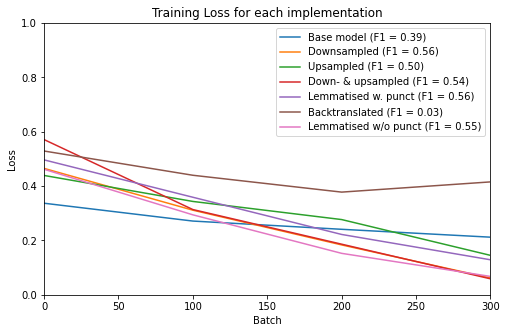

In [ ]:
# Recorded loss values for different implementations of the model
baseline_loss = np.array([0.3369, 0.2713, 0.2410, 0.2120, 0.2727, 0.2107, 0.1947])
downsample_loss = np.array([0.4651, 0.3113, 0.1835, 0.0619])
upsample_loss = np.array([0.4391, 0.3435, 0.2768, 0.1451])
down_upsample_loss = np.array([0.5711, 0.3136, 0.1862, 0.0588])
lemmatised_loss = np.array([0.4964, 0.3589, 0.2220, 0.1288])
backtranslated_loss = np.array([0.5290, 0.4398, 0.3778, 0.4154, 0.3843, 0.3832, 0.3817])
lemmatised_no_punct_loss = np.array([0.4618, 0.2942, 0.1525, 0.0676])

losses = [
    (baseline_loss, "Base model (F1 = 0.39)"),
    (downsample_loss, "Downsampled (F1 = 0.56)"),
    (upsample_loss, "Upsampled (F1 = 0.50)"),
    (down_upsample_loss, "Down- & upsampled (F1 = 0.54)"),
    (lemmatised_loss, "Lemmatised w. punct (F1 = 0.56)"),
    (backtranslated_loss, "Backtranslated (F1 = 0.03)"),
    (lemmatised_no_punct_loss, "Lemmatised w/o punct (F1 = 0.55)")
]

figure, axis = plt.subplots()


for loss, label in losses:
    batches = np.arange(0, len(loss) * 100, 100)
    axis.plot(batches, loss, label=label)

figure.set_size_inches((8, 5))

axis.set_ylabel("Loss")
axis.set_xlabel("Batch")
axis.set_title("Training Loss for each implementation")
axis.set_xlim(0, 300)
axis.set_ylim(0, 1)

axis.legend()

plt.show()

### Report F1 Score

In [ ]:
tokenizer = DebertaTokenizer.from_pretrained("microsoft/deberta-base")

#your saved model name here
model_name = './'
model = DebertaForSequenceClassification.from_pretrained(model_name)

# we don't batch our test set unless it's too big
test_loader = DataLoader(test_dataset)

report, annotated_test_dataset = evaluate(model, tokenizer, test_loader, test_df)

print(report)

print(report['accuracy'])
print(report[0]['f1-score'])
print(report[1]['f1-score'])

loading file https://huggingface.co/microsoft/deberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/ce0ac094af27cf80bbf403595a6d47f1fc632981bf1d4c5bf69968568cbea410.e8ad27cc324bb0dc448d4d95f63e48f72688fb318a4c4c3f623485621b0b515c
loading file https://huggingface.co/microsoft/deberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/05056f257c8d2b63ad16fd26f847c9ab9ee34e33cdfad926e132be824b237869.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/microsoft/deberta-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/microsoft/deberta-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/microsoft/deberta-base/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/c2bc27a1c7529c177696ff76b1e74cba8667be14e202359f20f9114e407f43e2.a39abb1c6179fb264c2db685f9a056b7cb8

  0%|          | 0/2094 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


{0: {'precision': 0.9408465068842428, 'recall': 0.9736147757255936, 'f1-score': 0.9569502074688796, 'support': 1895}, 1: {'precision': 0.6240601503759399, 'recall': 0.41708542713567837, 'f1-score': 0.5, 'support': 199}, 'accuracy': 0.9207258834765998, 'macro avg': {'precision': 0.7824533286300913, 'recall': 0.695350101430636, 'f1-score': 0.7284751037344398, 'support': 2094}, 'weighted avg': {'precision': 0.9107412132141606, 'recall': 0.9207258834765998, 'f1-score': 0.9135246624419899, 'support': 2094}}
0.9207258834765998
0.9569502074688796
0.5


### Analysis of F1 score with different intensities

In [ ]:
def get_intensity_histograms(df, intensity, axis):
    intensity_df = df.loc[df.intensity.map(int) == intensity]
    series = intensity_df.prediction.map(int)
    _, _, [patch0, patch1] = axis.hist(series, bins=[-0.5, 0.5, 1.5])

    patch0.set_facecolor("tab:blue")
    patch1.set_facecolor("tab:orange")

    axis.set_xticks([0, 1], labels=["Unpatronising", "Patronising"])

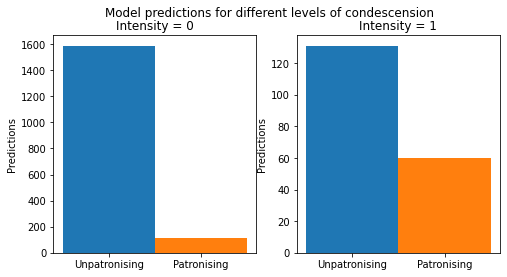

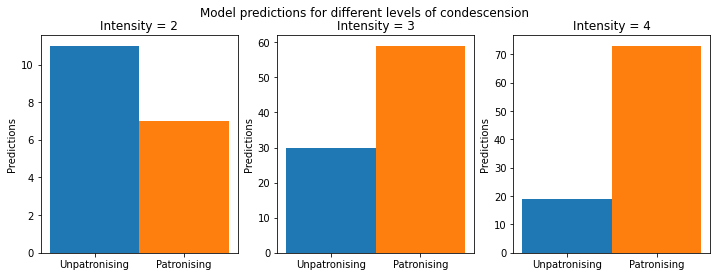

In [ ]:
figure_unpatr, (axis0, axis1) = plt.subplots(1, 2)

figure_unpatr.set_size_inches((8, 4))
figure_unpatr.suptitle("Model predictions for different levels of condescension")

axis0.set_ylabel("Predictions")
axis1.set_ylabel("Predictions")

axis0.set_title("Intensity = 0")
axis1.set_title("Intensity = 1")

series = get_intensity_histograms(annotated_test_dataset, 0, axis0)
series = get_intensity_histograms(annotated_test_dataset, 1, axis1)

figure_patr, (axis2, axis3, axis4) = plt.subplots(1, 3)

figure_patr.set_size_inches(12, 4)
figure_patr.suptitle("Model predictions for different levels of condescension")

axis2.set_ylabel("Predictions")
axis3.set_ylabel("Predictions")
axis4.set_ylabel("Predictions")

axis2.set_title("Intensity = 2")
axis3.set_title("Intensity = 3")
axis4.set_title("Intensity = 4")

get_intensity_histograms(annotated_test_dataset, 2, axis2)
get_intensity_histograms(annotated_test_dataset, 3, axis3)
get_intensity_histograms(annotated_test_dataset, 4, axis4)

In [ ]:
def intensity_f1_score(df):
    f1_scores = list()

    for intensity in range(5):
        intensity_df = df.loc[df.intensity.map(int) == intensity]
        labels = intensity_df.label.tolist()
        predictions = intensity_df.prediction.tolist()
        
        score = f1_score(labels, predictions)
        f1_scores.append(score)
    
    return f1_scores

In [ ]:
intensity_f1_score(annotated_test_dataset)

[0.0, 0.0, 0.56, 0.7972972972972973, 0.8848484848484849]

### Analysis of F1 score with different input lengths

In [ ]:
def input_length_f1_score(df):
    results = list()
    
    for lb in np.arange(0, 200, 20):
        ub = lb + 20
        length_df = df.loc[df.length >= lb]
        length_df = length_df.loc[length_df.length < ub]

        predictions = length_df.prediction.map(int)
        labels = length_df.label.map(int)

        score = f1_score(labels, predictions)
        results.append((score, f"{lb} <= n < {ub}"))
    
    scores, labels = zip(*results)

    return list(scores), list(labels)

/Users/louismanestar/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/louismanestar/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Text(0, 0.5, 'F1 Score')

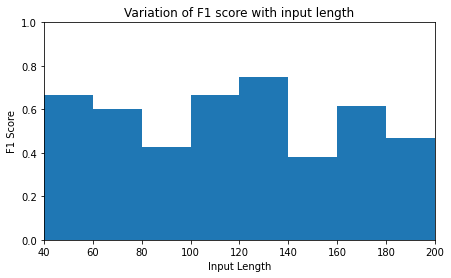

In [ ]:
scores, labels = input_length_f1_score(annotated_test_dataset)

figure, axis = plt.subplots()
figure.set_size_inches((7, 4))

axis.bar(np.arange(10, 210, 20), scores, width=20)

axis.set_xlim(40, 200)
axis.set_ylim(0, 1)

#axis.set_xticks(np.arange(40, 200, 20))

axis.set_title("Variation of F1 score with input length")
axis.set_xlabel("Input Length")
axis.set_ylabel("F1 Score")

### Analysis of F1 score with different categories

In [ ]:
def categories_f1_score(df):
    results = list()
    
    for category in np.unique(df.keyword):
        category_df = df.loc[df.keyword == category]
        predictions = category_df.prediction
        labels = category_df.label

        score = f1_score(labels, predictions)
        results.append((score, category))
    
    results.sort(key=itemgetter(0), reverse=True)
    scores, labels = zip(*results)

    return list(scores), list(labels)

Text(0, 0.5, 'F1 Score')

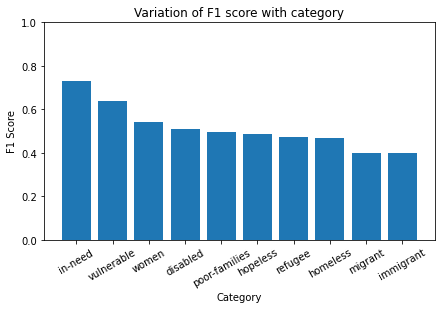

In [ ]:
figure, axis = plt.subplots()
figure.set_size_inches((7, 4))

scores, labels = categories_f1_score(annotated_test_dataset)
axis.bar(np.arange(len(labels)), scores, tick_label=labels)

axis.set_ylim(0, 1)
axis.tick_params(axis='x', labelrotation=30)

axis.set_title("Variation of F1 score with category")
axis.set_xlabel("Category")
axis.set_ylabel("F1 Score")

### Analysis of F1 score with different countries

In [ ]:
def country_f1_score(df):
    results = list()
    
    for country in np.unique(df.country):
        country_df = df.loc[df.country == country]
        predictions = country_df.prediction
        labels = country_df.label

        score = f1_score(labels, predictions)
        results.append((score, country))
    
    results.sort(key=itemgetter(0), reverse=True)
    scores, labels = zip(*results)

    return list(scores), list(labels)

Text(0, 0.5, 'F1 Score')

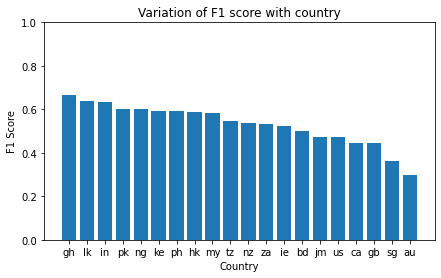

In [ ]:
figure, axis = plt.subplots()
figure.set_size_inches((7, 4))

scores, labels = country_f1_score(annotated_test_dataset)
axis.bar(np.arange(len(labels)), scores, tick_label=labels)

axis.set_ylim(0, 1)

axis.set_title("Variation of F1 score with country")
axis.set_xlabel("Country")
axis.set_ylabel("F1 Score")